# Paramteridentifikation

## Least Squares Schätzer

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.optimize import leastsq
from scipy import signal
import matplotlib.pyplot as plt
import time

$$

L_{a} \frac{\partial}{\partial t} i_{a} = u_{a} - R_{a} i_{a} - k_{a} \omega   \\

J_{r} \frac{\partial}{\partial t} \omega = k_{a} i_{a} - d_{v} \omega - d_{c} sign(\omega)
$$

mit der allgemeinen Lösung

$$
x = (A^{T}A)^{-1}A^{T}y
$$


damit ergibt sich 





$$
R_{a} = 1.379 \Omega \\
k_{a} = 0.0652 \frac{V s}{rad} \\
d_{c} = 0.0188 Nm \\
d_{v} = 43.3 · 10−6  \frac{N m s}{rad}
$$


und Allgmein mit den Matrixen

$$
Ax = y   \\
\begin{bmatrix}
i & -\omega & 0 & 0   \\
i & 0 & sign(\omega) & -\omega
\end{bmatrix}

\begin{bmatrix}
R \\ k \\ d_{c} \\ d_{v}
\end{bmatrix}
=
\begin{bmatrix}
u_{a} & 0
\end{bmatrix}

$$


In [66]:
# Einlesen der Daten
data = scipy.io.loadmat("Identifikation/data.mat")

rausch = True
filter = True

messwert = ['u_stat', 'i_stat', 'omega_stat']
if rausch == True:
    messwert = ['u_stat', 'i_rausch_stat', 'omega_rausch_stat']
    data = scipy.io.loadmat("Identifikation/data_rausch.mat")
   

#print(data)
u_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[0]]])
i_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[1]]])
omega_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[2]]])

# Transformieren der Messwerte in 1D arrays
u_Stat = u_Stat.flatten()
i_Stat = i_Stat.flatten()
omega_Stat = omega_Stat.flatten()

y = np.hstack([u_Stat, i_Stat, omega_Stat])

# Filter zum Glätten der Messwerte

if filter == True:
    N = 100
    win = signal.windows.hann(N)    
    y_filter = signal.oaconvolve(y, win, mode='same') / sum(win)
    y_filter = np.reshape(y_filter,(3,len(u_Stat)))
    # Abschneiden der Überlappung mit dem Kern jeweils die halbe Filterbreite
    y_filter = np.delete(y_filter,slice(len(u_Stat)-int(N/2), len(u_Stat)),1)  
    y_filter = np.delete(y_filter,slice(int(N/2)),1)
    y = y_filter.copy()
else:
    y = np.reshape(y,(3,len(u_Stat)))

# Festlegen der Startwerte
param = np.array([1, 0.01, 0.01, 0])


# Definition der nichlinearen Funktion, welche optimiert werden soll
def function(param, u, i, omega):
    R, k, dc, dv = param[0], param[1], param[2], param[3]
          
    f1 = (u-R*i-k*omega)
    f2 = (k*i-dv*omega-dc*np.sign(omega))

    return np.concatenate((f1, f2))

# Aufrufen der Optimierung
best, cov, info, message, ier = leastsq(function, param,(y[0],y[1],y[2]),full_output=True)
print(" Best-Fit Parameters: ",  best)




 Best-Fit Parameters:  [1.37155712e+00 6.52191681e-02 1.88340726e-02 4.24711609e-05]


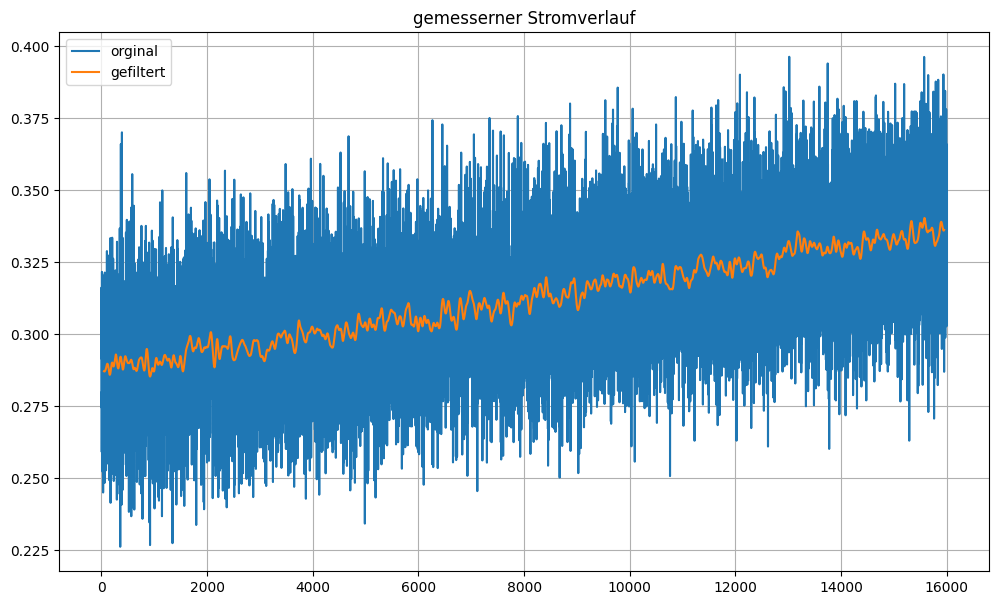

In [67]:
# Plottem der Ergebnisse
n=int(N/2)
x=np.linspace(1,len(u_Stat),len(u_Stat))

plt.figure(figsize=(12,7))
plt.plot(x,i_Stat)
plt.plot(x[n:len(x)-n],y_filter[1,:])
plt.grid(True)
plt.title('gemesserner Stromverlauf')
plt.legend(['orginal','gefiltert'])
plt.show()

In [73]:
from timeit import default_timer as timer

# Alternative ermittlung mittels Matrixinversion
u_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[0]]])
i_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[1]]])
omega_Stat = np.array([[element for element in upperElement] for upperElement in data[messwert[2]]])

# Transformieren der Messwerte in 1D arrays
#u_Stat = u_Stat.flatten()
#i_Stat = i_Stat.flatten()
#omega_Stat = omega_Stat.flatten()


yN = np.vstack([u_Stat,u_Stat*0 ])

A1 = np.hstack([i_Stat,omega_Stat])

x_inv = np.linalg.inv(A1.T@A1)
x = x_inv@A1.T@u_Stat

display(x.flatten())


array([1.34821967, 0.06537015])

# Recursive Least Squares (RLS)



lt. Skriptum TU-Wien, Automatisierungstechnik 1, S28 ff
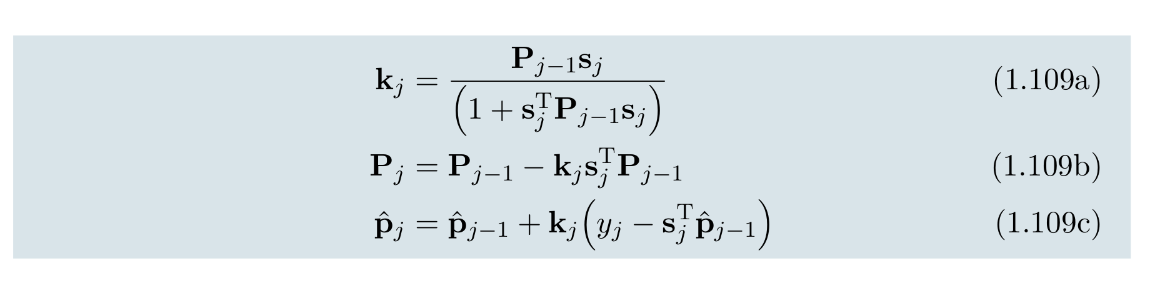

Die Ergebnisse des Verfahrens hängen maßgeblich von der Startmatrix P ab.   
Wahl der Startwerte:
$$
P_{0} = \alpha I
$$
Für große Werte von Alpha geht der RLS gegen den tatsächlichen Wert.

In [74]:
import math

xmin   = [0,0]
xmax   = [np.inf,np.inf]

def rlse_online(s,y,x_old,P_old):
    """ Recursive Least Square Estimator
        Skriptum Regelungssysteme 1, S.28 ff 

        Params
         --------
        s:             [y_k-1 ... u_k-1 ...]
        y:             [y_k]
        x_old:         Parameter vector  [a1, .... a2, b0, ....., bm ] der Länge m
        P_old:         inverser Messvektor (s.T@s)^-1
        
        Returns
        --------
        x:             new Parameter vector
        P:             new inverser Messvektor                     
    """

    lamda = 0.98                          # Vergessenheitsfaktor --> neue Messwerte werden stärker gewichtet   = gewichtete kleinste Quadrate     
    
    K = P_old@s.T / (lamda+s@P_old@s)     # Verstärkung für den neuen Schätzwert  --> K ist Vektor der Länge m     
    x = x_old + K.T*(y-s@x_old)           # Update Parametervektor
    P = (P_old - K@s*P_old)/lamda         # Update Pseudoinverse Messmatrix
       
    x = x.flatten()
         
    # Zustandsbeschränkungen
    
    for i in range(0,len(x_old)):
        if x[i] < xmin[i] or x[i] > xmax[i] :
            x[i] = min(xmax[i],max(xmin[i],x[i]))       
    return x,P


def LMS_online(s,y,x_old,u_quer = 0.1):
    """ Least-Mean Square Estimator = stochastisches Gradientenverfahren
        Skriptum Regelungssysteme 1, S.34 ff 

        Params
         --------
        s:             [y_k-1 ... u_k-1 ...]
        y:             [y_k]
        x_old:         Parameter vector  [a1, .... a2, b0, ....., bm ] der Länge m    
        u_quer:        skalar,  muss für die Konvergenz hinreichend klein gewählt werden    
        
        Returns
        --------
        x:             new Parameter vector                        
    """    
    
    u = u_quer/(s.T@s)
    x = x_old + u*(y-s.T@x_old)   
    
    return x

y = u_Stat.copy()
A = np.hstack([i_Stat,omega_Stat])

#Alternative wahl der Anfangsmatrixen mit Vorwissen
n = 20
nx = 2
tol = 1

A_init = A[0:n,:]
y_init = y[0:n]
P = np.linalg.inv(A_init.T@A_init)

x = P@A_init.T@y_init
x = x.flatten()
x_LMS = x.copy()
#P = np.eye(nx)*1e+2


RLS = np.zeros((len(y),nx))
LMS = RLS.copy()
Time  = np.zeros(len(y))




for k in range(1,len(y)):
    start = timer()
    RLS[k,:] = x
    LMS[k,:] = x_LMS

    # Herausfiltern von unrealstischen Daten    
    if abs(y[k,:]-y[k-1,:]) > tol:
        y[k] = y[k-1]           
    
    x,P    = rlse_online(A[k,:],y[k,:],x,P) 
    x_LMS  = LMS_online(A[k,:],y[k,:],x_LMS)

    Time[k] = timer()-start
    if math.isnan(x[0]):
        print(k)
        break 
    

print(RLS[-1,:])
print(LMS[-1,:])


[1.36092211 0.0652142 ]
[1.45540427 0.06480208]


16000


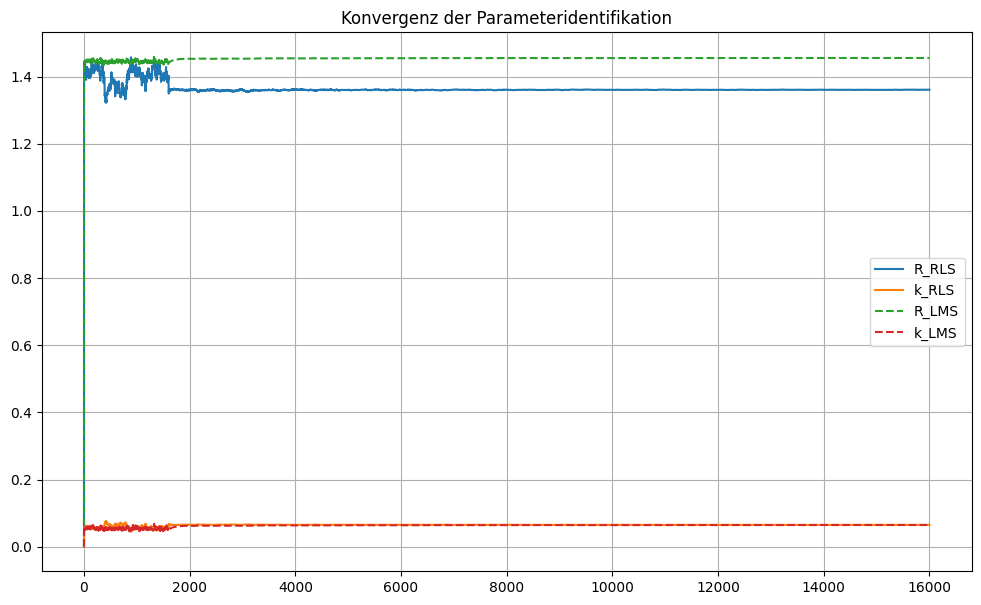

In [76]:
t=np.linspace(1,len(y),len(y))
print(len(t))

N = 16000

plt.figure(figsize=(12,7))
plt.plot(t[0:N],RLS[0:N,0],  label = 'R_RLS')
plt.plot(t[0:N],RLS[0:N,1],  label = 'k_RLS')
plt.plot(t[0:N],LMS[0:N,0], '--', label = 'R_LMS')
plt.plot(t[0:N],LMS[0:N,1], '--', label = 'k_LMS')
plt.grid(True)
plt.title('Konvergenz der Parameteridentifikation')
#plt.ylim([-2,2])
plt.legend()
plt.show()

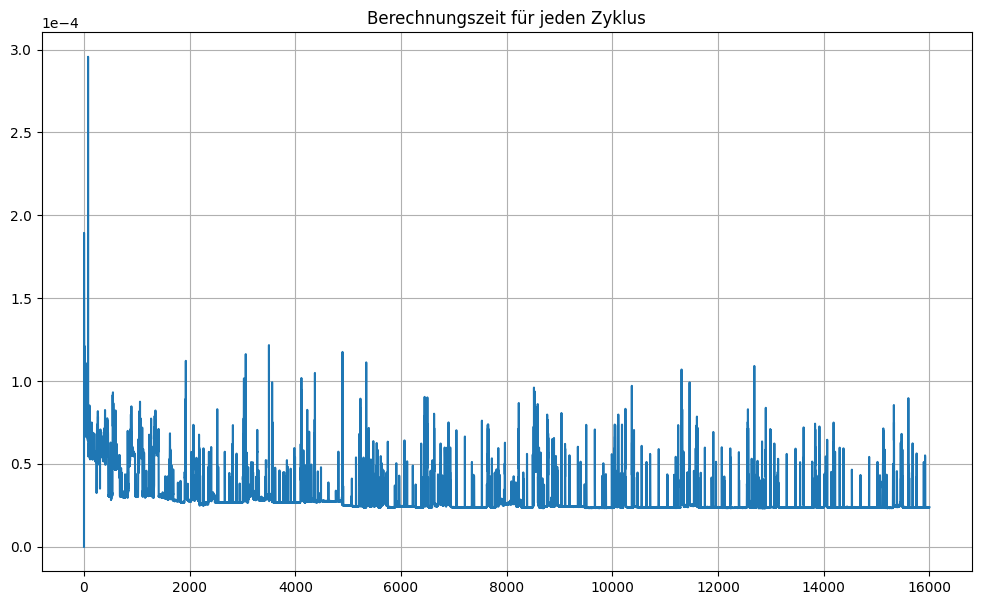

In [71]:
plt.figure(figsize=(12,7))
plt.plot(t,Time)
plt.grid(True)
plt.title('Berechnungszeit für jeden Zyklus')
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.show()